Check-point file

Load training and validation list

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data import AUTOTUNE

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import pickle

In [19]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
with open('training_list.data', 'rb') as filehandle:
    # Store the data as a binary data stream
    training_list = pickle.load(filehandle)

with open('validation_list.data', 'rb') as filehandle:
    # Store the data as a binary data stream
    validation_list = pickle.load(filehandle)

In [37]:
#random.shuffle(training_list)
#random.shuffle(validation_list)

In [22]:
#training_list = training_list[:10000]
#validation_list = validation_list[:50]

Load dataset and error functions

In [4]:
def load_element(element):
    #make tensors list delimited by ,
    element = tf.strings.split(element, sep=",")
    #load image
    img = tf.io.read_file(element[0])
    #make sure is 3 channels
    #the pretrained model requires [0,255] values
    img = tf.image.decode_jpeg(img, channels=3)
    #conver to float [0,1)
    #img = tf.image.convert_image_dtype(img, dtype=tf.float16)
    #resize
    img = tf.image.resize(img, (128, 128))
    #category
    #category = tf.constant(element[1])
    category =tf.strings.to_number(element[1], tf.int32)
    #bounding box
    x_min = tf.strings.to_number(element[2])
    y_min = tf.strings.to_number(element[3])
    x_max = tf.strings.to_number(element[4])
    y_max = tf.strings.to_number(element[5])
    bb = [x_min, y_min, x_max, y_max]

    labels = {'class_output': category, 'box_output':bb}

    return (img, labels)

In [5]:
bath_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(training_list)
train_dataset = (train_dataset
                .shuffle(len(training_list))
                .map(load_element, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(bath_size)
                .prefetch(AUTOTUNE)
                )

val_dataset = tf.data.Dataset.from_tensor_slices(validation_list)
val_dataset = (val_dataset
                #.shuffle(len(validation_list))
                .map(load_element, num_parallel_calls = AUTOTUNE)
                .cache()
                .batch(bath_size)
                .prefetch(AUTOTUNE)
                )


In [31]:
def my_GIoU(bb_true, bb_pred):
    #make zero as tensor
    zero = tf.convert_to_tensor(0.0, bb_true.dtype)
    #convert them to tensor clases
    Ax1, Ay1, Ax2, Ay2 = tf.unstack(bb_true, 4, axis=-1)
    Bx1, By1, Bx2, By2 = tf.unstack(bb_pred, 4, axis=-1)

    #for the bounding box predicted make sure Bx2 > Bx1 y By2 > By1
    bx1 = tf.math.minimum(Bx1, Bx2)
    by1 = tf.math.minimum(By1, By2)
    bx2 = tf.math.maximum(Bx1, Bx2)
    by2 = tf.math.maximum(By1, By2)

    #calculate area of true bounding box
    A_area = (Ax2 - Ax1)*(Ay2 - Ay1)
    #calculate area of predicted bounding box
    B_area = (bx2 - bx1)*(by2 - by1)
    
    #calculate intersection over true and pred
    #find the box overlaps both boxes
    #each inter calculates the smallest stride
    x_inter_1 = tf.math.maximum(bx1, Ax1)
    y_inter_1 = tf.math.maximum(by1, Ay1)
    x_inter_2 = tf.math.minimum(bx2, Ax2)
    y_inter_2 = tf.math.minimum(by2, Ay2)
    #get width
    w_inter = tf.maximum(zero, x_inter_2 - x_inter_1)
    #get height
    h_inter = tf.maximum(zero, y_inter_2 - y_inter_1)
    #intersection
    I = w_inter * h_inter
    #area over union
    area_union = (B_area + A_area) - I
    iou = tf.math.divide_no_nan(I, area_union)

    #find the b box C smaller that surrounding/fits both A and B
    Cx1 = tf.math.minimum(bx1, Ax1)
    Cy1 = tf.math.minimum(by1, Ay1)
    Cx2 = tf.math.maximum(bx2, Ax2)
    Cy2 = tf.math.maximum(by2, Ay2)

    #calculate the C area
    C_area = (Cx2 - Cx1) * (Cy2 - Cy1)
    #calculate giou
    giou = iou - tf.math.divide_no_nan(C_area - area_union, C_area)
    #calculate mean of all observations
    m_giou = tf.reduce_mean(giou, axis=0)

    return m_giou

def my_GIoULoss(bb_true, bb_pred):
    return 1.0 - my_GIoU(bb_true, bb_pred)

def my_sparse_category_accurary(y_true, y_pred):
    #y_true is expected to be integer
    #y_pred is a numpy.ndarray with the normalized probabilities
    acc = np.dot(1, np.not_equal(y_true, np.argmax(y_pred, axis=1)))
    return acc

def my_IoU_np(y_true, y_pred):
    #becausse model predict returns a numpy.ndarray then convert to tensors because the function already works as tensors
    bb_true = tf.convert_to_tensor(y_true, y_pred.dtype)
    bb_pred = tf.convert_to_tensor(y_pred, y_pred.dtype)

    #make zero as tensor
    zero = tf.convert_to_tensor(0.0, bb_true.dtype)
    #convert them to tensor clases
    Ax1, Ay1, Ax2, Ay2 = tf.unstack(bb_true, 4, axis=-1)
    Bx1, By1, Bx2, By2 = tf.unstack(bb_pred, 4, axis=-1)

    #for the bounding box predicted make sure Bx2 > Bx1 y By2 > By1
    bx1 = tf.math.minimum(Bx1, Bx2)
    by1 = tf.math.minimum(By1, By2)
    bx2 = tf.math.maximum(Bx1, Bx2)
    by2 = tf.math.maximum(By1, By2)

    #calculate area of true bounding box
    A_area = (Ax2 - Ax1)*(Ay2 - Ay1)
    #calculate area of predicted bounding box
    B_area = (bx2 - bx1)*(by2 - by1)
    
    #calculate intersection over true and pred
    #find the box overlaps both boxes
    #each inter calculates the smallest stride
    x_inter_1 = tf.math.maximum(bx1, Ax1)
    y_inter_1 = tf.math.maximum(by1, Ay1)
    x_inter_2 = tf.math.minimum(bx2, Ax2)
    y_inter_2 = tf.math.minimum(by2, Ay2)
    #get width
    w_inter = tf.maximum(zero, x_inter_2 - x_inter_1)
    #get height
    h_inter = tf.maximum(zero, y_inter_2 - y_inter_1)
    #intersection
    I = w_inter * h_inter
    #area over union
    area_union = (B_area + A_area) - I
    iou = tf.math.divide_no_nan(I, area_union)

    #find the b box C smaller that surrounding/fits both A and B
    Cx1 = tf.math.minimum(bx1, Ax1)
    Cy1 = tf.math.minimum(by1, Ay1)
    Cx2 = tf.math.maximum(bx2, Ax2)
    Cy2 = tf.math.maximum(by2, Ay2)

    #calculate the C area
    C_area = (Cx2 - Cx1) * (Cy2 - Cy1)
    #calculate giou
    giou = iou - tf.math.divide_no_nan(C_area - area_union, C_area)
    #convert back to numpy
    giou = giou.numpy()
    #check if is over 50% then 0 otherwise 1
    over_50 = np.where(iou>0.5, 0, 1)

    return over_50

def custom_error(y_true_cat, y_pred_cat, y_true_bb, y_pred_bb):
    d = my_sparse_category_accurary(y_true_cat, y_pred_cat)
    f = my_IoU_np(y_true_bb, y_pred_bb)
    e = np.max(np.column_stack((d,f)), axis=1)
    return d, f, e, e.mean()

In [7]:
# For classification we will have sparse categorical crossentropy
# For the bouding boxes we will have GIoU
losses = { 
    "class_output": tf.keras.losses.SparseCategoricalCrossentropy(),
    "box_output": my_GIoULoss
    }

# For the class labels we want to know the Accuracy
# And for the bounding boxes we need to know GIoU
metrics = {
    'class_output': tf.keras.metrics.SparseCategoricalAccuracy(), 
    'box_output': my_GIoU
    }

stop = EarlyStopping(monitor = "val_loss", min_delta = 0.001, patience = 40, 
                    restore_best_weights = True
                     )

In [8]:
reconstructed_model = tf.keras.models.load_model('model.keras', custom_objects={'my_GIoULoss':my_GIoULoss, 'my_GIoU':my_GIoU})

Train

In [39]:
model_history = reconstructed_model.fit(x=train_dataset, validation_data=val_dataset, epochs=2, callbacks=stop, verbose=2)

Epoch 1/2
3125/3125 - 4762s - loss: 1.9996 - class_output_loss: 1.5558 - box_output_loss: 0.4438 - class_output_sparse_categorical_accuracy: 0.6296 - box_output_my_GIoU: 0.5562 - val_loss: 2.0735 - val_class_output_loss: 1.6243 - val_box_output_loss: 0.4492 - val_class_output_sparse_categorical_accuracy: 0.6285 - val_box_output_my_GIoU: 0.5509 - 4762s/epoch - 2s/step
Epoch 2/2
3125/3125 - 4147s - loss: 1.8213 - class_output_loss: 1.3800 - box_output_loss: 0.4413 - class_output_sparse_categorical_accuracy: 0.6560 - box_output_my_GIoU: 0.5587 - val_loss: 2.0704 - val_class_output_loss: 1.6218 - val_box_output_loss: 0.4486 - val_class_output_sparse_categorical_accuracy: 0.6294 - val_box_output_my_GIoU: 0.5515 - 4147s/epoch - 1s/step


In [106]:
with open('history', 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [43]:
reconstructed_model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [41]:
reconstructed_model.save('model.keras')

In [110]:
with open('history', "rb") as file_pi:
    history = pickle.load(file_pi)

predict

In [10]:
predictions = reconstructed_model.predict(val_dataset)
y_pred_cat, y_pred_bb = predictions

313/313 [==============================] - 337s 1s/step


In [11]:
y_true_cat = np.array([-1])
y_true_bb = np.array([-1, -1, -1, -1])
for element in val_dataset.as_numpy_iterator():
    #y_true_cat.insert(element[1]['class_output'])
    #y_true_bb.insert(element[1]['box_output'])

    y_true_cat = np.append(y_true_cat, element[1]['class_output'])
    y_true_bb = np.append(y_true_bb, element[1]['box_output'])

y_true_cat = y_true_cat[1:]
y_true_bb = y_true_bb[4:]

y_true_bb = y_true_bb.reshape((10000,4))

In [32]:
d, f, e, e_media = custom_error(y_true_cat, y_pred_cat, y_true_bb, y_pred_bb)

In [33]:
e, e_media

(array([0, 1, 0, ..., 1, 1, 1]), 0.5779)

In [34]:
1-e_media

0.42210000000000003

In [35]:
d.mean()

0.3706

In [36]:
f.mean()

0.4058

In [29]:
np.max(np.column_stack((e[:10], f[:10])), axis=1)

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 1])

In [30]:
np.max((e[:10], f[:10]), axis=0)

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 1])

In [108]:
def plot(var1, var2, plot_name):
    # Get the loss metrics from the trained model
    c1 = history[var1]
    c2 = history[var2]

    epochs = range(len(c1))

    # Plot the metrics
    plt.plot(epochs, c1, 'b', label=var1)
    plt.plot(epochs, c2, 'r', label=var2)
    plt.title(str(plot_name))
    plt.legend()

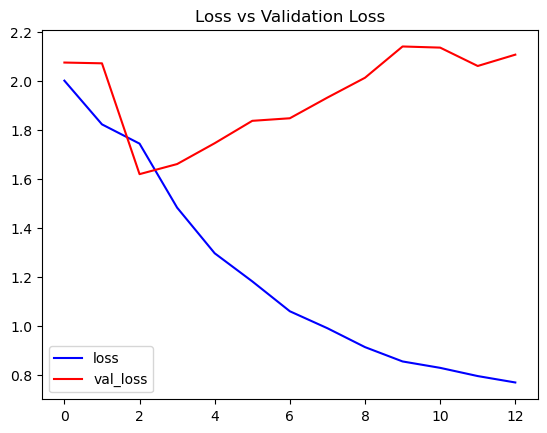

In [112]:
plot( 'loss', 'val_loss', 'Loss vs Validation Loss')

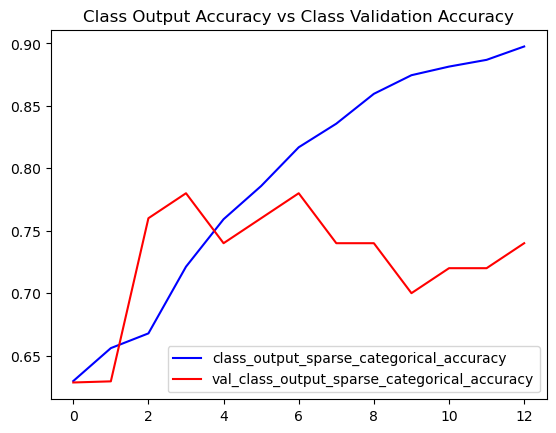

In [109]:
plot( 'class_output_sparse_categorical_accuracy', 'val_class_output_sparse_categorical_accuracy', 'Class Output Accuracy vs Class Validation Accuracy')

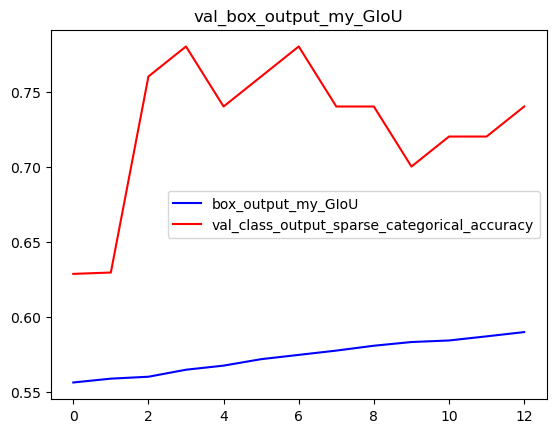

In [111]:
plot( 'box_output_my_GIoU', 'val_class_output_sparse_categorical_accuracy', 'val_box_output_my_GIoU')